In [1]:
# --- Standard libraries
import os.path as osp
import heapq as hq
import matplotlib.pyplot as plt
# --- PyTorch
import torch
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
from utils import pred_spec, calculate_rse, bokeh_spectra
# --- Bokeh
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
# --- XASNet
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.utils import GraphDataProducer
from XASNet.utils.visualisation import plot_prediction
from XASNet.utils.rse import rse_predictions, rse_loss, rse_histogram

Loading BokehJS ...

In [2]:
# --- Load in the test dataset
test_dataset = torch.load('./datasets/mol_test_dataset.pt')

In [10]:
# --- Print details of the dataset
print(f'Number of graphs: {len(test_dataset)}')
print('')

# --- Print details of the first molecule/graph in the dataset
data = test_dataset[2]

print(data)
print('------------')
print(f'Molecule index: {data.idx}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 48

Data(x=[29, 15], edge_index=[2, 76], edge_attr=[76, 6], spectrum=[200], pos=[29, 3], z=[29], idx=[1], smiles='C123[C:2]4([CH:1]=[CH:23][CH:22]5[C:20]1([OH:25])[C:16]16[C:12]78[C:8]9([CH:4]2[C:6]([OH:27])([CH:5]=[CH:3]4)[CH:7]=[CH:9][C:10]9=[CH:11][CH:13]=[C:14]7[CH:15]=[CH:17][C:18]1([CH:19]=[CH:21]5)[O:26]6)[O:24]8)[O:28]3')
------------
Molecule index: tensor([9])
Number of nodes: 29
Number of edges: 76
Average node degree: 2.62
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [11]:
data.idx

tensor([9])

##### XASNet GNN

In [12]:
# --- Set device for model to run on
device = 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [15, 64, 128, 256], # input nodes for each layer
    out_channels = [64, 128, 256, 512], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 4, # number of layers
    heads = 0
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_gnn_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

##### XASNet GAT

In [63]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=15,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=200,
    n_layers=4,
    n_heads=3,
    gat_type='gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet_gat_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

##### XASNet GrahNet

In [7]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=17,
    edge_dim=6,
    hidden_channels=512,
    out_channels=200,
    gat_hidd=512,
    gat_out=200,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet_graphnet_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

RuntimeError: Error(s) in loading state_dict for XASNet_GraphNet:
	Missing key(s) in state_dict: "graphnets.0.gatencoder.gats.0.att", "graphnets.0.gatencoder.gats.0.bias", "graphnets.0.gatencoder.gats.0.lin_l.weight", "graphnets.0.gatencoder.gats.0.lin_l.bias", "graphnets.0.gatencoder.gats.0.lin_r.weight", "graphnets.0.gatencoder.gats.0.lin_r.bias", "graphnets.0.gatencoder.gats.2.att", "graphnets.0.gatencoder.gats.2.bias", "graphnets.0.gatencoder.gats.2.lin_l.weight", "graphnets.0.gatencoder.gats.2.lin_l.bias", "graphnets.0.gatencoder.gats.2.lin_r.weight", "graphnets.0.gatencoder.gats.2.lin_r.bias", "graphnets.0.gatencoder.gats.4.att", "graphnets.0.gatencoder.gats.4.bias", "graphnets.0.gatencoder.gats.4.lin_l.weight", "graphnets.0.gatencoder.gats.4.lin_l.bias", "graphnets.0.gatencoder.gats.4.lin_r.weight", "graphnets.0.gatencoder.gats.4.lin_r.bias", "graphnets.0.gatencoder.gats.6.att", "graphnets.0.gatencoder.gats.6.bias", "graphnets.0.gatencoder.gats.6.lin_l.weight", "graphnets.0.gatencoder.gats.6.lin_l.bias", "graphnets.0.gatencoder.gats.6.lin_r.weight", "graphnets.0.gatencoder.gats.6.lin_r.bias", "graphnets.0.node_model.mlp.0.weight", "graphnets.0.node_model.mlp.0.bias", "graphnets.0.node_model.mlp.2.weight", "graphnets.0.node_model.mlp.2.bias", "graphnets.0.node_model.mlp.4.weight", "graphnets.0.node_model.mlp.4.bias", "graphnets.0.edge_model.mlp.0.weight", "graphnets.0.edge_model.mlp.0.bias", "graphnets.0.edge_model.mlp.2.weight", "graphnets.0.edge_model.mlp.2.bias", "graphnets.0.edge_model.mlp.4.weight", "graphnets.0.edge_model.mlp.4.bias", "graphnets.0.global_model.mlp.0.weight", "graphnets.0.global_model.mlp.0.bias", "graphnets.0.global_model.mlp.2.weight", "graphnets.0.global_model.mlp.2.bias", "graphnets.0.global_model.mlp.4.weight", "graphnets.0.global_model.mlp.4.bias", "graphnets.1.gatencoder.gats.0.att", "graphnets.1.gatencoder.gats.0.bias", "graphnets.1.gatencoder.gats.0.lin_l.weight", "graphnets.1.gatencoder.gats.0.lin_l.bias", "graphnets.1.gatencoder.gats.0.lin_r.weight", "graphnets.1.gatencoder.gats.0.lin_r.bias", "graphnets.1.gatencoder.gats.2.att", "graphnets.1.gatencoder.gats.2.bias", "graphnets.1.gatencoder.gats.2.lin_l.weight", "graphnets.1.gatencoder.gats.2.lin_l.bias", "graphnets.1.gatencoder.gats.2.lin_r.weight", "graphnets.1.gatencoder.gats.2.lin_r.bias", "graphnets.1.gatencoder.gats.4.att", "graphnets.1.gatencoder.gats.4.bias", "graphnets.1.gatencoder.gats.4.lin_l.weight", "graphnets.1.gatencoder.gats.4.lin_l.bias", "graphnets.1.gatencoder.gats.4.lin_r.weight", "graphnets.1.gatencoder.gats.4.lin_r.bias", "graphnets.1.gatencoder.gats.6.att", "graphnets.1.gatencoder.gats.6.bias", "graphnets.1.gatencoder.gats.6.lin_l.weight", "graphnets.1.gatencoder.gats.6.lin_l.bias", "graphnets.1.gatencoder.gats.6.lin_r.weight", "graphnets.1.gatencoder.gats.6.lin_r.bias", "graphnets.1.node_model.mlp.0.weight", "graphnets.1.node_model.mlp.0.bias", "graphnets.1.node_model.mlp.2.weight", "graphnets.1.node_model.mlp.2.bias", "graphnets.1.node_model.mlp.4.weight", "graphnets.1.node_model.mlp.4.bias", "graphnets.1.edge_model.mlp.0.weight", "graphnets.1.edge_model.mlp.0.bias", "graphnets.1.edge_model.mlp.2.weight", "graphnets.1.edge_model.mlp.2.bias", "graphnets.1.edge_model.mlp.4.weight", "graphnets.1.edge_model.mlp.4.bias", "graphnets.1.global_model.mlp.0.weight", "graphnets.1.global_model.mlp.0.bias", "graphnets.1.global_model.mlp.2.weight", "graphnets.1.global_model.mlp.2.bias", "graphnets.1.global_model.mlp.4.weight", "graphnets.1.global_model.mlp.4.bias", "graphnets.2.gatencoder.gats.0.att", "graphnets.2.gatencoder.gats.0.bias", "graphnets.2.gatencoder.gats.0.lin_l.weight", "graphnets.2.gatencoder.gats.0.lin_l.bias", "graphnets.2.gatencoder.gats.0.lin_r.weight", "graphnets.2.gatencoder.gats.0.lin_r.bias", "graphnets.2.gatencoder.gats.2.att", "graphnets.2.gatencoder.gats.2.bias", "graphnets.2.gatencoder.gats.2.lin_l.weight", "graphnets.2.gatencoder.gats.2.lin_l.bias", "graphnets.2.gatencoder.gats.2.lin_r.weight", "graphnets.2.gatencoder.gats.2.lin_r.bias", "graphnets.2.gatencoder.gats.4.att", "graphnets.2.gatencoder.gats.4.bias", "graphnets.2.gatencoder.gats.4.lin_l.weight", "graphnets.2.gatencoder.gats.4.lin_l.bias", "graphnets.2.gatencoder.gats.4.lin_r.weight", "graphnets.2.gatencoder.gats.4.lin_r.bias", "graphnets.2.gatencoder.gats.6.att", "graphnets.2.gatencoder.gats.6.bias", "graphnets.2.gatencoder.gats.6.lin_l.weight", "graphnets.2.gatencoder.gats.6.lin_l.bias", "graphnets.2.gatencoder.gats.6.lin_r.weight", "graphnets.2.gatencoder.gats.6.lin_r.bias", "graphnets.2.node_model.mlp.0.weight", "graphnets.2.node_model.mlp.0.bias", "graphnets.2.node_model.mlp.2.weight", "graphnets.2.node_model.mlp.2.bias", "graphnets.2.node_model.mlp.4.weight", "graphnets.2.node_model.mlp.4.bias", "graphnets.2.edge_model.mlp.0.weight", "graphnets.2.edge_model.mlp.0.bias", "graphnets.2.edge_model.mlp.2.weight", "graphnets.2.edge_model.mlp.2.bias", "graphnets.2.edge_model.mlp.4.weight", "graphnets.2.edge_model.mlp.4.bias", "graphnets.2.global_model.mlp.0.weight", "graphnets.2.global_model.mlp.0.bias", "graphnets.2.global_model.mlp.2.weight", "graphnets.2.global_model.mlp.2.bias", "graphnets.2.global_model.mlp.4.weight", "graphnets.2.global_model.mlp.4.bias", "output_dense.weight", "output_dense.bias". 
	Unexpected key(s) in state_dict: "batch_norms.0.weight", "batch_norms.0.bias", "batch_norms.0.running_mean", "batch_norms.0.running_var", "batch_norms.0.num_batches_tracked", "batch_norms.1.weight", "batch_norms.1.bias", "batch_norms.1.running_mean", "batch_norms.1.running_var", "batch_norms.1.num_batches_tracked", "batch_norms.2.weight", "batch_norms.2.bias", "batch_norms.2.running_mean", "batch_norms.2.running_var", "batch_norms.2.num_batches_tracked", "interaction_layers.0.bias", "interaction_layers.0.lin.weight", "interaction_layers.1.bias", "interaction_layers.1.lin.weight", "interaction_layers.2.bias", "interaction_layers.2.lin.weight", "out.weight", "out.bias". 

##### View predictions

In [13]:
predict = {}
true = {}

for data in enumerate(test_dataset):
    predict[data[0]], true[data[0]] = pred_spec(xasnet_gnn, data, test_dataset, graphnet=False)

In [14]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(true[x], predict[x])
    rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f'Average spearman correlation coefficient = {sum(spear) / len(spear)}')
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.04280780961653807
Average spearman correlation coefficient = 0.9425555326383163
Average MSE = 0.008520146777700282
Average RSE = 0.04250921226259726


In [15]:
rank_rse = hq.nsmallest(48, rse)

rank_graph = []

for x in range(39):
    rank_idx = rse.index(rank_rse[x])
    rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {rank_rse[x]:.4f}, graph number = {rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {rank_rse[x]:.4f}, graph number = {rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.0188, graph number = 15
RSE = 0.0273, graph number = 28
RSE = 0.0280, graph number = 45
RSE = 0.0288, graph number = 7
RSE = 0.0294, graph number = 5

The 5 worst RSE values are:
RSE = 0.1023, graph number = 12
RSE = 0.0682, graph number = 47
RSE = 0.0619, graph number = 46
RSE = 0.0608, graph number = 30
RSE = 0.0585, graph number = 1


In [16]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(predict[rank_graph[0]], true[rank_graph[0]])
p2 = bokeh_spectra(predict[rank_graph[1]], true[rank_graph[1]])
p3 = bokeh_spectra(predict[rank_graph[2]], true[rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [17]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(predict[rank_graph[-1]], true[rank_graph[-1]])
p2 = bokeh_spectra(predict[rank_graph[-2]], true[rank_graph[-2]])
p3 = bokeh_spectra(predict[rank_graph[-3]], true[rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [ ]:
from scipy.stats import spearmanr

spear = spearmanr(y_true, y_pred)

print(spear)
print(spear[0])

SignificanceResult(statistic=0.9618420460511514, pvalue=2.091425829965994e-113)
0.9618420460511514


In [ ]:
import numpy as np

for i in range(200):
    if y_pred[i] < 0:
        y_pred[i] = 0.00000000001

sid = 0

for i in range(200):
    temp = y_pred[i] * np.log(y_pred[i]/y_true[i]) + y_true[i] * np.log(y_true[i]/y_pred[i])
    sid = sid + temp

print(sid)

tensor(1.9581, dtype=torch.float64)


In [ ]:
rse_dict = rse_predictions(xasnet_gnn, test_dataset, graphnet=False)

In [ ]:
rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [ ]:
rse_loss(y_pred, y_true)

tensor(0.0288, dtype=torch.float64)

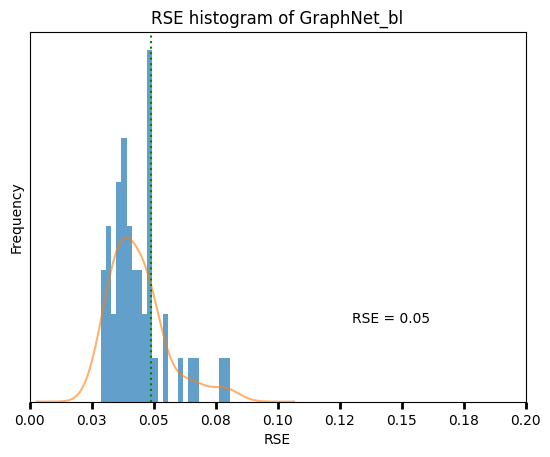

In [ ]:
rse_histogram(list(rse_dict.values()), 
              bins=25, 
              quantiles=False,
              model_name="GraphNet_bl", 
              save=False)

### Circumcoronene

In [89]:
circum_dataset = torch.load('./datasets/mol_cir_dataset.pt')

In [90]:
# --- Show details of the dataset
print(circum_dataset)
print('------------')
print(f'Number of graphs: {len(circum_dataset)}')
print(f'Number of features: {circum_dataset.num_features}')
print(f'Number of classes: {circum_dataset.num_classes}')

# --- Show details of the first molecule/graph in the dataset
circum_data = circum_dataset[0]
print(circum_data)
print('------------')
print(f'Number of nodes: {circum_data.num_nodes}')
print(f'Number of edges: {circum_data.num_edges}')
print(f'Average node degree: {circum_data.num_edges / circum_data.num_nodes:.2f}')
print(f'Has isolated nodes: {circum_data.has_isolated_nodes()}')
print(f'Has self loops: {circum_data.has_self_loops()}')
print(f'Is undirected: {circum_data.is_undirected()}')

XASDataset(91)
------------
Number of graphs: 91
Number of features: 15
Number of classes: 0
Data(x=[59, 15], edge_index=[2, 158], edge_attr=[158, 6], spectrum=[200], pos=[59, 3], z=[59], idx=[1], smiles='c12[c:1]3[c:2]4[c:3]([cH:4][cH:5]1)[cH:38][c:39]1[c:40]5[c:9]4[c:8]4[c:7]6[c:6]3[c:24]3[c:23]([cH:22]2)[cH:31][cH:32][c:33]2[c:25]3[c:26]3[c:10]6[c:11]6[c:12]7[c:13]4[c:42]4[c:41]5[c:49]([cH:48][cH:47]1)[cH:50][c:51]1[c:43]4[c:44]4[c:17]7[c:16]5[c:15]7[c:14]6[c:28]6[c:27]3[C:35]3([CH:34]2[O:58]3)[CH:36]=[CH:37][c:29]6[cH:30][c:18]7[c:19]([C:54](=[O:56])[OH:57])[cH:20][c:21]5[cH:46][c:45]4[CH:53]2[CH:52]1[O:55]2')
------------
Number of nodes: 59
Number of edges: 158
Average node degree: 2.68
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [124]:
# --- Set device for model to run on
device = 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gatv2', # model type
    in_channels = [15, 64], # input nodes for each layer
    out_channels = [64, 128], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 2, # number of layers
    heads = 0
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_gnn_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

In [125]:
cir_predict = {}
cir_true = {}

for data in enumerate(circum_dataset):
    cir_predict[data[0]], cir_true[data[0]] = pred_spec(xasnet_gnn, data, circum_dataset, graphnet=False)

In [126]:
cir_wasser = []
cir_mse = []
cir_rse = []
cir_spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(cir_true[x], cir_predict[x])
    cir_wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(cir_true[x], cir_predict[x])
    cir_mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(cir_true[x], cir_predict[x])
    cir_rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(cir_true[x], cir_predict[x])
    cir_spear.append(spear_temp[0])

print(f"Average Wasserstein distance = {sum(cir_wasser) / len(cir_wasser)}")
print(f'Average spearman correlation coefficient = {sum(cir_spear) / len(cir_spear)}')
print(f"Average MSE = {sum(cir_mse) / len(cir_mse)}")
print(f'Average RSE = {sum(cir_rse) / len(cir_rse)}')

Average Wasserstein distance = 0.043624282742179006
Average spearman correlation coefficient = 0.9584078039450987
Average MSE = 0.007149475487489471
Average RSE = 0.05585367601024205


In [127]:
cir_rank_rse = hq.nsmallest(91, cir_rse)

cir_rank_graph = []

for x in range(39):
    rank_idx = cir_rse.index(cir_rank_rse[x])
    cir_rank_graph.append(rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {cir_rank_rse[x]:.4f}, graph number = {cir_rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {cir_rank_rse[x]:.4f}, graph number = {cir_rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.0295, graph number = 3
RSE = 0.0307, graph number = 18
RSE = 0.0328, graph number = 19
RSE = 0.0329, graph number = 31
RSE = 0.0361, graph number = 11

The 5 worst RSE values are:
RSE = 0.0889, graph number = 22
RSE = 0.0790, graph number = 46
RSE = 0.0775, graph number = 12
RSE = 0.0733, graph number = 28
RSE = 0.0726, graph number = 10


In [128]:
# --- Plot best spectra prediction
cir_p1 = bokeh_spectra(cir_predict[cir_rank_graph[0]], cir_true[rank_graph[0]])
cir_p2 = bokeh_spectra(cir_predict[cir_rank_graph[1]], cir_true[rank_graph[1]])
cir_p3 = bokeh_spectra(cir_predict[cir_rank_graph[2]], cir_true[rank_graph[2]])
cir_p = row(cir_p1, cir_p2, cir_p3)
show(cir_p)
#export_png(cir_, filename='GO_mol_best_RSE.png')

In [129]:
# --- Plot worst spectra prediction
cir_p1 = bokeh_spectra(cir_predict[cir_rank_graph[-1]], cir_true[rank_graph[-1]])
cir_p2 = bokeh_spectra(cir_predict[cir_rank_graph[-2]], cir_true[rank_graph[-2]])
cir_p3 = bokeh_spectra(cir_predict[cir_rank_graph[-3]], cir_true[rank_graph[-3]])
cir_p = row(cir_p1, cir_p2, cir_p3)
show(cir_p)
#export_png(p, filename='GO_mol_best_RSE.png')